## this homework will be split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Wednesday 15th at midnight, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

In [0]:
# ----------------------
# Author : P. Mondal
# Date : 07 April, 2020
# ----------------------


## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 



In [0]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# TASK:  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqic an grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


'/content/data'

In [0]:

%mkdir data
%cd data

!wget "https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz"

/content/data/data
--2020-04-08 23:27:53--  https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21553100 (21M) [application/octet-stream]
Saving to: ‘plasticc_train_lightcurves.csv.gz’

plasticc_train_ligh 100%[===================>]  20.55M  5.38MB/s    in 3.8s    

2020-04-08 23:27:58 (5.38 MB/s) - ‘plasticc_train_lightcurves.csv.gz’ saved [21553100/21553100]



In [0]:
%ls
# !unzip plasticc_train_lightcurves.csv.gz
!gunzip -k plasticc_train_lightcurves.csv.gz

plasticc_train_lightcurves.csv.gz


In [0]:
%ls

 data/  'plasticc_train_lightcurves.csv.gz?download=1'   sample_data/


In [0]:
%cd data

/content/data


In [0]:
%ls

 data/  'plasticc_train_lightcurves.csv.gz?download=1'


In [0]:
# NOTE::: this is not a reproducible way to do it!!!!!! this would cost points

lcvs = pd.read_csv("data/plasticc_train_lightcurves.csv")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])
## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)

lcvs = lcvs#[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)


The dataset contains: (observations, columns) (1421705, 6)


In [0]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands (see overview.) 

In [0]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [0]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [0]:
%cd data/
!wget "https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz"

/content/data/data
--2020-04-09 08:46:53--  https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 370350 (362K) [application/octet-stream]
Saving to: ‘plasticc_train_metadata.csv.gz.2’

plasticc_train_meta 100%[===================>] 361.67K   327KB/s    in 1.1s    

2020-04-09 08:46:56 (327 KB/s) - ‘plasticc_train_metadata.csv.gz.2’ saved [370350/370350]



In [0]:
%ls
%cd ../

plasticc_train_lightcurves.csv     plasticc_train_metadata.csv.gz.1
plasticc_train_lightcurves.csv.gz  plasticc_train_metadata.csv.gz.2
plasticc_train_metadata.csv.gz
/content/data


In [0]:
metadata = pd.read_csv("data/plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')

In [0]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 26)


* Deliverable: make sure you print statements like the ones above summarizing the size of the datasets you acquire and you show the beginning of each dataset



# TASK : data visualization - plot some time series 
You always need to visualize your data to get a sense of what we are working with
that for each object I have 6 bands: each object is plotted separately, all bands for each object are plotted together.

**Include object 84716**


In [0]:
# preparing a normalization to pass to the color map to map red filters to red
# blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

In [0]:
# Include object 84716

lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [0]:
# print(abs(lcvs['object_id']-615))
data_obj = np.array(lcvs['object_id'])
# Find specific number in an array
print(abs(lcvs['object_id']) )


0                615
1                615
2                615
3                615
4                615
             ...    
1421700    130779836
1421701    130779836
1421702    130779836
1421703    130779836
1421704    130779836
Name: object_id, Length: 1421705, dtype: int64


In [0]:
  lcvs1 = lcvs.loc[lcvs['object_id'] == 84716]
  lcvs1['object_id']

164073    84716
164074    84716
164075    84716
164076    84716
164077    84716
          ...  
164323    84716
164324    84716
164325    84716
164326    84716
164327    84716
Name: object_id, Length: 255, dtype: int64

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


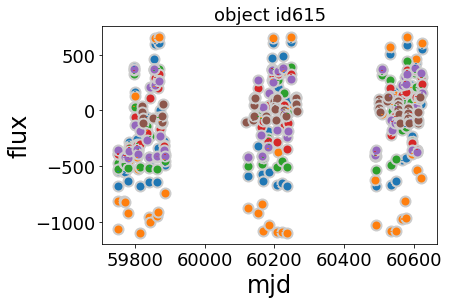

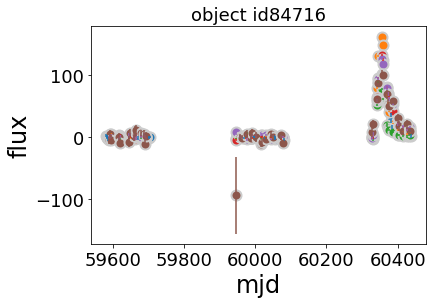

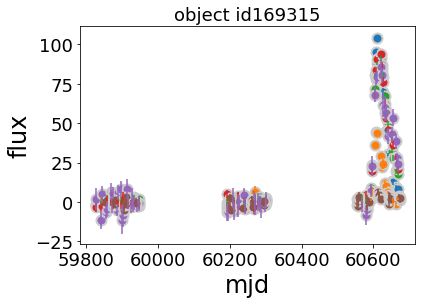

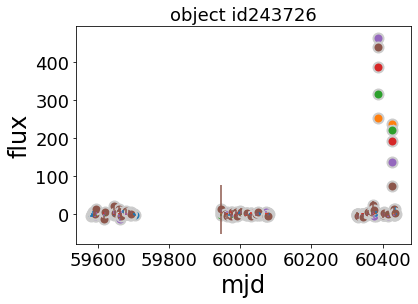

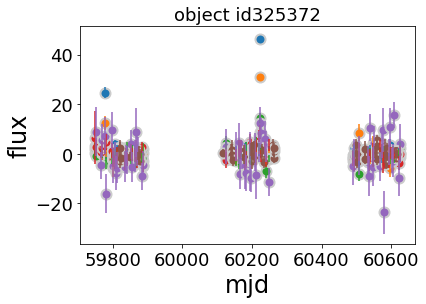

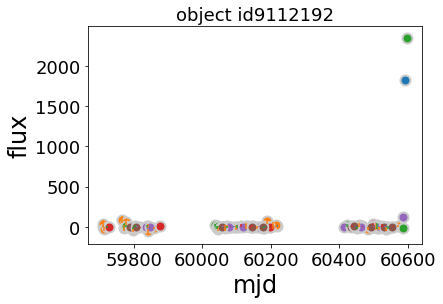

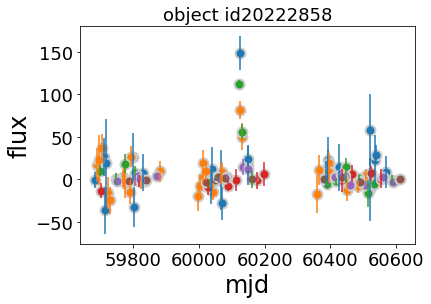

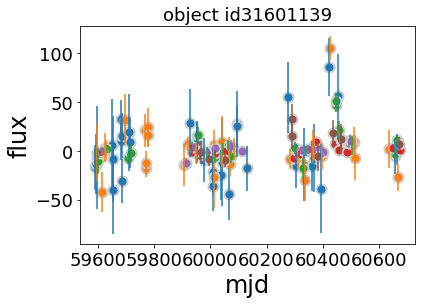

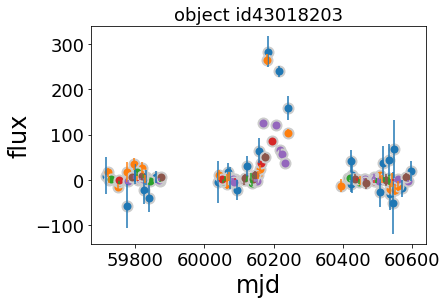

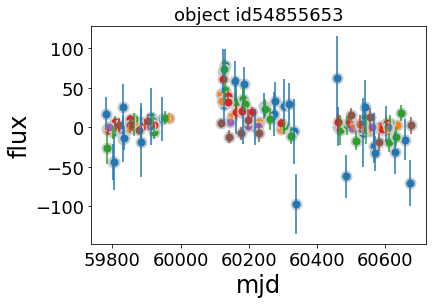

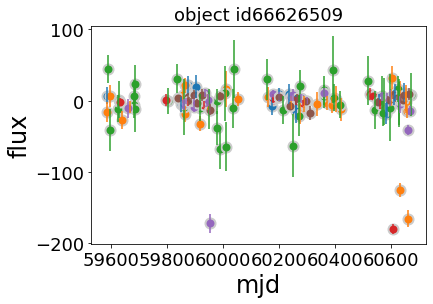

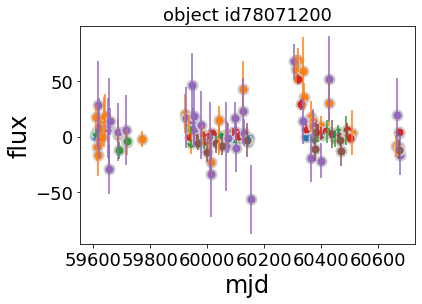

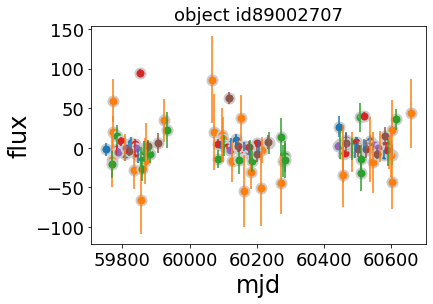

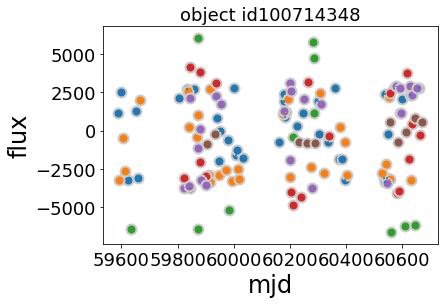

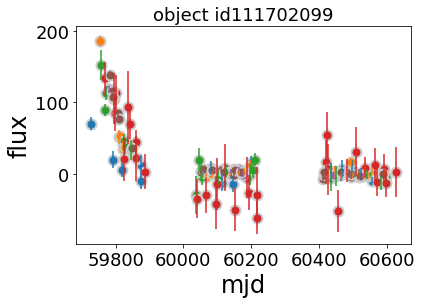

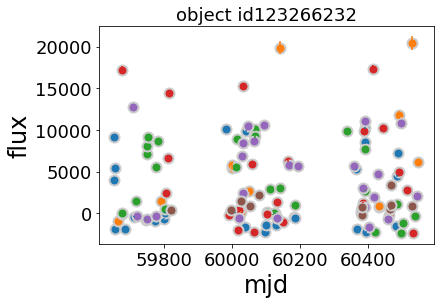

In [0]:
obj_id = [615, 84716, 169315, 243726, 325372, 9112192, 20222858, 31601139, 
          43018203, 54855653, 66626509, 78071200, 89002707, 100714348, 111702099,
          123266232]
for ii in obj_id:
  # Creates a new dataframe with obj_id = 615 only
  lcvs1 = pd.DataFrame(index=lcvs.index, columns=lcvs.columns)
  lcvs1 = lcvs.loc[lcvs['object_id'] == ii]
  # print(lcvs1['object_id'])

  ax = lcvs1.plot.scatter(x='mjd', y='flux', title = 'object id'+ str(ii))
  #lcvs1.errorbar(x='mjd', y = 'flux', yerr='flux_err')
  
  for f in lcvs1['passband'].unique():
     pl.errorbar(lcvs1.loc[lcvs1["passband"] == f, "mjd"], 
                lcvs1.loc[lcvs1["passband"] == f, "flux"],
                yerr=lcvs1.loc[lcvs1["passband"] == f, "flux_err"], fmt='.', ms=0,
                fcolor=None, label=None)
  
# replot to add a better marker (optional)
  for f in lcvs1['passband'].unique():
     pl.scatter(lcvs1.loc[lcvs1["passband"] == f, "mjd"], 
                lcvs1.loc[lcvs1["passband"] == f, "flux"], 
                alpha=1, s=100, linewidth=2,
                label=f,
                edgecolor='#cccccc')
  
  
     SMALL_SIZE = 18
     MEDIUM_SIZE = 10
     BIGGER_SIZE = 12

     pl.rc('font', size=SMALL_SIZE)          # controls default text sizes

     pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
     pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
     pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
     pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
     axis_font = {'fontname':'Computer Modern Roman', 'size':'24'}
     pl.xlabel("mjd", **axis_font)
     pl.ylabel("flux", **axis_font)
     pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  
  # How do I get a good colormap ????
  

Fig1 : The above plot shows change in flux for different time "mjd" for different object ids. The error in measurements are shown with errorbars.Some of the observations have higher errors (object id 111702099) compared to others. The flux intensity time series also changes with observation id.  
The observation id 123266232 has an interesting feature showing three astronominal events noted by higher data accumulation during certain time period (three noticeable cluster of points).  

/Users/fbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


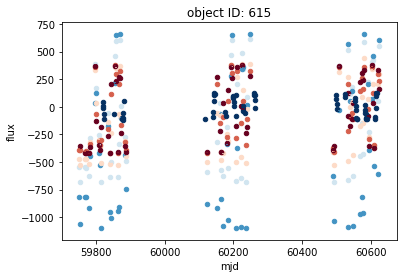

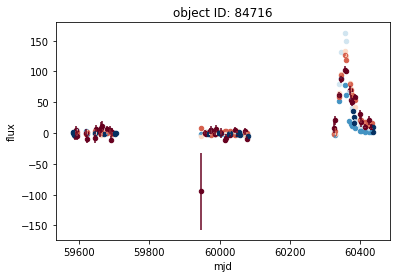

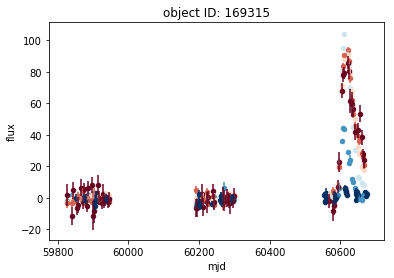

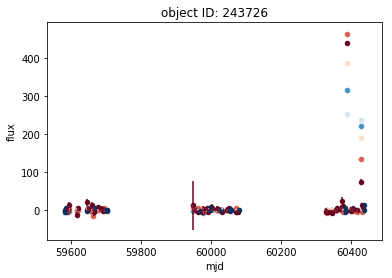

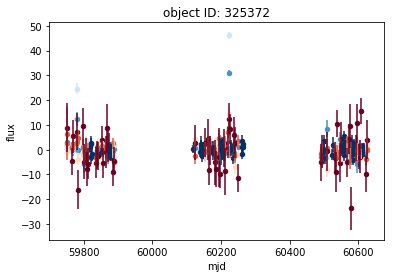

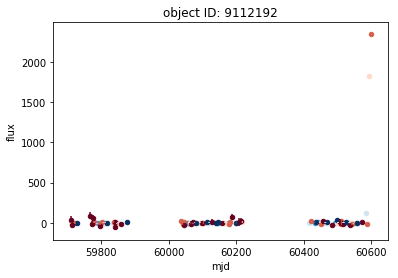

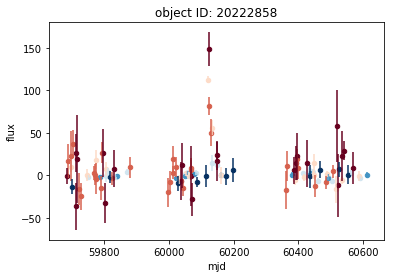

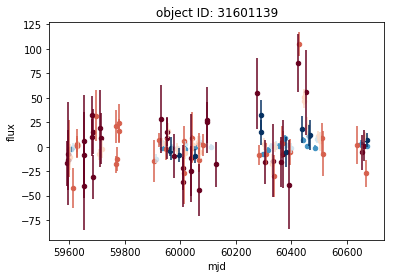

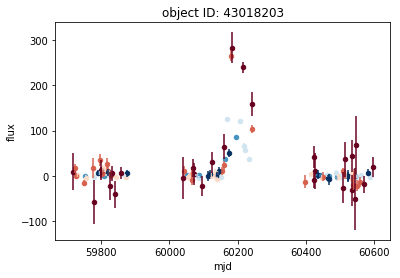

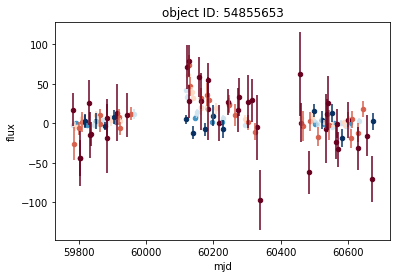

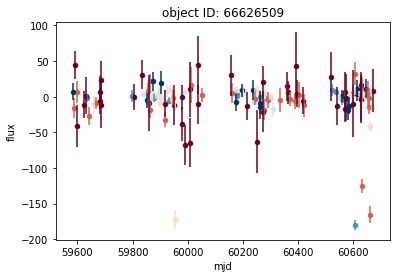

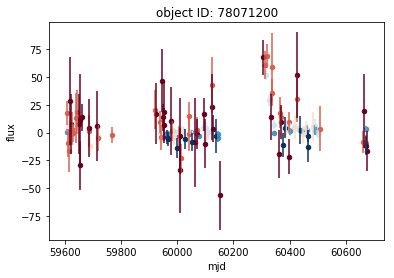

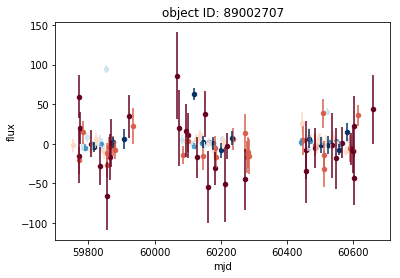

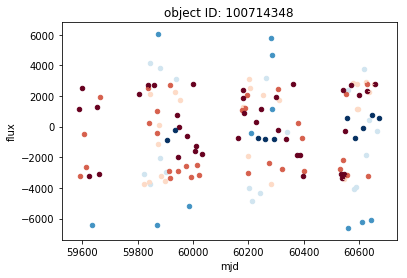

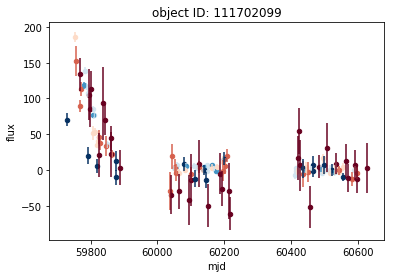

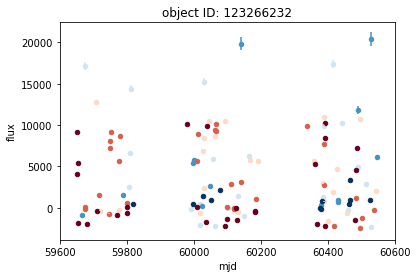

In [0]:
# -- plot one ever 100o objects
pl/data
...


* Deliverable: make a plot for a subset of the objects (~10 at least). Describe what you are plotting and any notable things you see in the figure. Make sure you plot the time series (flux) against time (mjd) and also display the uncertainties int he measurement (fluxerr)

# TASK: Extract features
*You do not have to extract exaclyt the features I am extracting! These are just examples! Extract at least 6 features including 2 features from all three category below* 

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

We will work similarly, extracting some basic features for each lightcurve. 

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 

My plan is to extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slop of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl ; important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)

I am ok with you extracting different features! 

Extract **at least 6 features including 2 features from all three category above**: original lcv, standardized lcv, metadata. Justify each feature. Remember that if the features are extracted from the time series there will be 6 features for each choice of feature (for 6 passbands) so I end up with 94 features with the scheme outlined above

## TASK: 4.1
describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

        

Ans : The features I would like to extract are :
    

*   From the original lightcurve:
    * mean (continuous, unbound)
    * standard deviation (continuous, unbound)
    * The two features will tell us the mean value and how much it's spread around the mean i.e. standard deviation.  
*   From the standardized lightcurve
    * Slope of a line fit (continuous, unbound)
    * intercept of a line fit (continuous, unbound)
    * The two features will tell how well the data fits a line and what is the minimal value at t = 0 i.e. intercept.
*   From the metadata file:
    * decl ; important because the position on the sky may determin if it is a galactic or extragalactic object (categorical)
    * ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series (binary)
    * Useful for unstructured data and easier to handle.
    * important because the position on the sky may determin if it is a galactic or extragalactic object
    * the kind of survey i.e. the data collection scheme that lead to the time series



## TASK 4.2 extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

### Example get the mean and standard deviation of the flux in each band for each object

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()
type(means)

pandas.core.frame.DataFrame

In [0]:
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                                axis=1), left_index=True, right_index=True)
features.head()

mean         std
object_id passband                        
615       0          -3.254554   83.944735
          1        -385.699911  601.787302
          2        -134.146566  455.121346
          3        -121.103501  335.425053
          4         -55.954592  291.803449

### higher order moments of the distribution can be obtained with the scipy.stats.moment() function which can be applied to a grouby() object
note that this way you can apply a function that takes only one argument, the argument over which groupby iterates (the flux here). But moments take 2: the value and the moment Create a unction call

In [0]:
# Calculating higher order moments 

from scipy import stats 
def momen2(x, ordr):
    """
    Author : P. Mondal
    Date : 07 April, 2020,
    Input :
      x     : array of dataset
      ordr : order of moment 
    """
    return stats.moment(x, moment = ordr)
m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(momen2, 2)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(momen2, 3)
type(m2)

pandas.core.series.Series

In [0]:
# Converting to dataframe
m2_d = m2.to_frame()
m2_d.head()
m3_d = m3.to_frame()
m3_d.head()

flux
object_id passband              
615       0         7.266579e+04
          1         8.593916e+07
          2         3.040627e+07
          3         1.049664e+07
          4         4.717542e+06

In [0]:

features = m2_d.rename({"flux": "skewness"}, 
                        axis=1).merge(m3_d.rename({"flux": "Kurthosis"}, 
                                axis=1), left_index=True, right_index=True)
features.head()


skewness     Kurthosis
object_id passband                             
615       0           6934.865833  7.266579e+04
          1         355904.026224  8.593916e+07
          2         203564.138816  3.040627e+07
          3         110570.138947  1.049664e+07
          4          83681.162283  4.717542e+06

### Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties becaus outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


In [0]:
maxs = lcvs.groupby(["object_id", "passband"])[["flux"]].max()
mins = lcvs.groupby(["object_id", "passband"])[["flux"]].min()
print(lcvs.shape)
print(maxs.shape)

(1421705, 6)
(47088, 1)


In [0]:
features = maxs.rename({"flux": "maxs"}, 
                        axis=1).merge(mins.rename({"flux": "mins"}, 
                                axis=1), left_index=True, right_index=True)
features.head()

maxs         mins
object_id passband                         
615       0         125.182808  -116.913223
          1         660.626343 -1100.440063
          2         611.984558  -681.858887
          3         445.737061  -530.644592
          4         381.953735  -422.184509

## TASK 4.3 Standardize the lcvs and extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

In [0]:
lcvs["fluxnormed"] = 0.

In [0]:
# normalize each LC this is very slow. can you make  it faster?
from sklearn import preprocessing

def normed(df):
   df["fluxnormed"]=((df["flux"] - df["flux"].mean())/( df["flux"].std()) )

   """
   x = df.values # Returns a numpy array
   min_max_scaler = preprocessing.MinMaxScaler()
   x_scaled = min_max_scaler.fit_transform(x)
   df = pd.DataFrame(x_scaled,  columns=df.columns)
   """
   return df
    
lcvs = lcvs.groupby(["object_id", "passband"]).apply(normed)

# this is how it could be done in a for loop. But it would take hours!!
#for obj in  objects:
#    for band in bands:
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux =\
#             lcvs[lcvs.object_id == obj][lcvs.passband == band].flux - means.loc[obj, band]
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux /= stds.loc[obj, band]        


In [0]:
"""
# since time column was nor,alized, I am adding unnormalized time column as "new_mjd"
lcvs_t.head()
lcvs_t['new_mjd'] = list(lcvs['mjd'])
"""

'\n# since time column was nor,alized, I am adding unnormalized time column as "new_mjd"\nlcvs_t.head()\nlcvs_t[\'new_mjd\'] = list(lcvs[\'mjd\'])\n'

In [0]:
lcvs.tail()

,object_id,mjd,passband,flux,flux_err,detected_bool,fluxnormed
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,-0.320627
1421701,130779836,60560.0459,1,14.894439,18.947685,0,-0.593104
1421702,130779836,60571.0225,5,30.593130,50.695290,0,-0.474355
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,-0.319136
1421704,130779836,60588.0372,0,-41.214264,51.665123,0,-0.402645


In [0]:
ii = 615
lcvs2 = lcvs.loc[lcvs['object_id'] == 615]
lcvs2.head()

,object_id,mjd,passband,flux,flux_err,detected_bool,fluxnormed
0,615,59750.4229,2,-544.810303,3.622952,1,-0.902317
1,615,59750.4306,1,-816.434326,5.553370,1,-0.715759
2,615,59750.4383,3,-471.385529,3.801213,1,-1.044293
3,615,59750.4450,4,-388.984985,11.395031,1,-1.141283
4,615,59752.4070,2,-681.858887,4.041204,1,-1.203442


findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


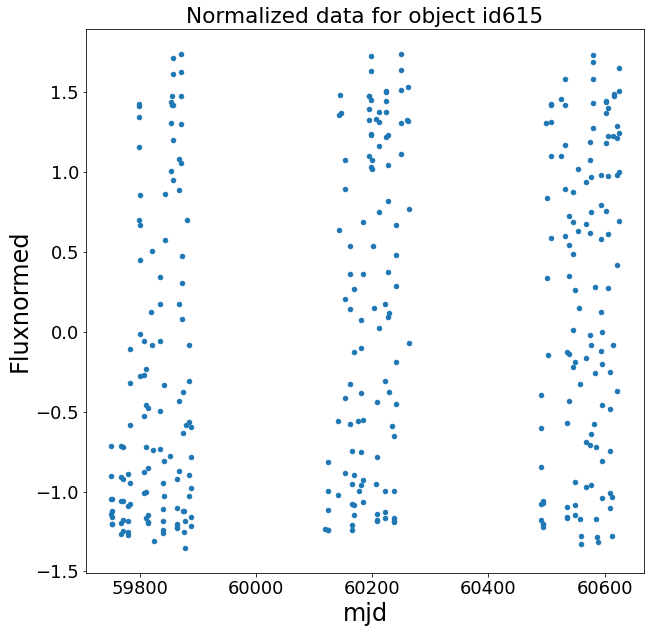

In [0]:
    ax = lcvs2.plot.scatter(x='mjd', y='fluxnormed', figsize=(10,10))
    SMALL_SIZE = 18
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
    pl.title('Normalized data for ' + 'object id'+ str(ii))
    pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    axis_font = {'fontname':'Computer Modern Roman', 'size':'24'}
    pl.xlabel("mjd", **axis_font)
    pl.ylabel("Fluxnormed", **axis_font)
    pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

Fig2 : Normalized flux vs mjd plot. One can also compare with previous unnormalized data for the specific observation id (observation id 615). 



/Users/fbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


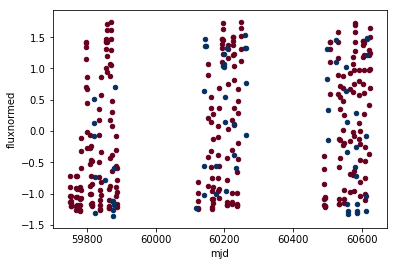

In [0]:
# replot the normalized time series to make sure I did it right
...

Figure 2: ...

### min and max: if I did not get the means before I would store these data. seance I have the mean and the min max of the not standardized data this is irrelevant


In [0]:
maxs_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].max()
mins_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].min()

### the median of the standardizeed distribution will convey the location of the "center of mass" of the data with respect to the mean


In [0]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()
print((medians.values[0][0]))

-0.08053716093009985


In [0]:
features['medians'] = [x[0] for x in medians.values[:]]


## TASK 4.4: parametric features: extract some features that come from simple models of the lightcurve



### fit a line to the standardized data and store the slope and intercept as new features. See here for how to apply this with a groupby https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
If you can use groupby you get an extra point (cause that would be a very efficient way to do it)

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    # print(pars)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

In [0]:
linfits.shape
linfits.values[0][1]
print(type(linfits))

<class 'pandas.core.series.Series'>


In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]
slopes[0]
intercepts[0]

-0.17594730087598728

In [0]:
features["slopes"] = slopes
features["intercepts"] = intercepts

### A quadratic function can tell you if the time series is concave or convex. 
### If we fit both line and a quadratic we can also us the likelihood ratio to see wchich fit is best (remember the first couple of classes)

In [0]:
# this is slow!!
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    m1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    m2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = m2.llf, m1.llf, np.sign(m2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [0]:
ols[0][2]

-1.0

In [0]:
ll1 = [x[0] for x in ols.values[:]]
ll2 = [x[1] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

## Task 5: show your engineered feature space and add features from the metadata file

Note that in the way I cereated the feature dataframe I have a feature column for each object and bandpass. I need to manipulate the dataframe so that I have 6xN features per object where N is the number of eatures I engineered. 

In [0]:
features.head()

maxs         mins  ...        ll2  ll3
object_id passband                           ...                
615       0         125.182808  -116.913223  ... -88.218652 -1.0
          1         660.626343 -1100.440063  ... -80.869998 -1.0
          2         611.984558  -681.858887  ... -80.109763 -1.0
          3         445.737061  -530.644592  ... -79.290039 -1.0
          4         381.953735  -422.184509  ... -78.480261 -1.0

[5 rows x 8 columns]

In [0]:
# unstack will do the trick ... 
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])


In [0]:
allfeatures.head()

passband            0                        ...          5                
                 maxs        mins   medians  ...        ll1        ll2  ll3
object_id                                    ...                           
615        125.182808 -116.913223 -0.080537  ... -76.917754 -77.386461 -1.0
713         14.509829  -14.735178 -0.052914  ... -65.167686 -65.424297 -1.0
730          5.942166   -3.459960  0.039463  ... -66.518080 -67.853917  1.0
745         18.014029   -3.874349 -0.169349  ... -64.783463 -77.536999 -1.0
1124         5.330927   -6.804703 -0.033864  ... -76.526495 -76.666778  1.0

[5 rows x 48 columns]

In [0]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
metadata.set_index('object_id')
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print(metadata.shape)
print(allfeatures.shape)

(7848, 26)
(7848, 48)


In [0]:
allfeatures = allfeatures.merge(metadata, left_on='object_id', right_on='object_id')
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,object_id,"(0, maxs)","(0, mins)","(0, medians)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll2)","(0, ll3)","(1, maxs)","(1, mins)","(1, medians)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, maxs)","(2, mins)","(2, medians)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, maxs)","(3, mins)","(3, medians)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, maxs)","(4, mins)","(4, medians)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, maxs)","(5, mins)","(5, medians)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.959510,-84.969286,-1.0,37.170177,-2.622109,-0.429236,0.028666,-0.816982,-67.527468,-69.333715,1.0,106.671692,-2.084535,-0.438785,0.025384,-0.723449,-71.247906,-72.170872,1.0,139.818405,-2.800270,-0.383411,0.021342,-0.608237,-74.498916,-74.891133,1.0,143.600189,-16.543753,-0.303771,0.019736,-0.562470,-75.898716,-75.991223,1.0,109.157585,-10.860540,-0.229697,0.015555,-0.435534,-76.526495,-76.666778,1.0,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
allfeatures.head()

,object_id,"(0, maxs)","(0, mins)","(0, medians)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll2)","(0, ll3)","(1, maxs)","(1, mins)","(1, medians)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, maxs)","(2, mins)","(2, medians)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, maxs)","(3, mins)","(3, medians)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, maxs)","(4, mins)","(4, medians)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, maxs)","(5, mins)","(5, medians)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.959510,-84.969286,-1.0,37.170177,-2.622109,-0.429236,0.028666,-0.816982,-67.527468,-69.333715,1.0,106.671692,-2.084535,-0.438785,0.025384,-0.723449,-71.247906,-72.170872,1.0,139.818405,-2.800270,-0.383411,0.021342,-0.608237,-74.498916,-74.891133,1.0,143.600189,-16.543753,-0.303771,0.019736,-0.562470,-75.898716,-75.991223,1.0,109.157585,-10.860540,-0.229697,0.015555,-0.435534,-76.526495,-76.666778,1.0,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
"""
allfeatures = allfeatures.merge(metadata, left_on='object_id', 
allfeatures.head()
"""

"\nallfeatures = allfeatures.merge(metadata, left_on='object_id', \nallfeatures.head()\n"

* Deliverable: what is the shape of your final feature space?
Ans : The shape is (7848, 74)
      with 68 features and 7848 number of observations.

In [0]:
print(allfeatures.shape)

(7848, 74)


In [0]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 74 features (columns)


## Task 6: Create your train and test set out of the feature matrix and preprocess them to remove correlation by scaling them along the feature axis
The goall is to have a fewature matrix, the endogenous variables, X, and the target vector, the y exogenous variable for each training and test set.
Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below.

### make sure you deal with missing data

In [0]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))


there are 0 NaN and 1 infinity entries


In [0]:
np.isfinite(allfeatures).sum()

object_id       7848
(0, maxs)       7848
(0, mins)       7848
(0, medians)    7848
(0, slopes)     7848
                ... 
tflux_g         7848
tflux_r         7848
tflux_i         7848
tflux_z         7848
tflux_y         7848
Length: 74, dtype: int64

I the problem is with one of the likelihoods. 
I can drop that feature from the dataset or replace with something else. 



In [0]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape


((7848, 74), (7847, 74))

In [0]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape


((7848, 74), (7848, 73))

In [0]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape


((7848, 74), (7848, 74))

In [0]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)


## split train-test set

In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

print(X.shape)
print(type(X))
import sklearn
from sklearn.model_selection import train_test_split
...
#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25. 
# I choose 60-40
# train_size = 60%*length(data)
train_size = round(0.6*len(X))
print(train_size)
X_train = X[:train_size]
y_train = y[:train_size]

# test size = 40%*length(data)
test_size = round(0.4*len(X))
X_test = X[-test_size:]
y_test = y[-test_size:]

(7848, 72)
<class 'pandas.core.frame.DataFrame'>
4709


In [0]:
test_size + train_size 
print(X_test)

      object_id    (0, maxs)   (0, mins)  ...  tflux_r  tflux_i  tflux_z
4709   59851245    11.632682  -23.237066  ...      0.0      0.0      0.0
4710   59889755    68.569366 -120.950943  ...  19202.2  11182.9   6283.7
4711   59907038   426.600830  -10.641991  ...      0.0      0.0      0.0
4712   59948995    29.780506  -12.810878  ...    990.0    863.1    620.0
4713   60022063     9.290782   -6.857703  ...      0.0      0.0      0.0
...         ...          ...         ...  ...      ...      ...      ...
7843  130739978    51.247578  -23.468113  ...    742.8   3295.1   6047.5
7844  130755807   271.930481  -22.168346  ...      0.0      0.0      0.0
7845  130762946    52.152622 -135.602631  ...   1445.1   1191.2    848.9
7846  130772921    37.959984  -11.813696  ...     49.4    244.3    534.8
7847  130779836  7761.321777  -41.214264  ...  36299.5  41257.7  43047.7

[3139 rows x 72 columns]


In [0]:
(X_train[:2])


,object_id,"(0, maxs)","(0, mins)","(0, medians)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll3)","(1, maxs)","(1, mins)","(1, medians)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, maxs)","(2, mins)","(2, medians)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, maxs)","(3, mins)","(3, medians)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, maxs)","(4, mins)","(4, medians)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, maxs)","(5, mins)","(5, medians)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z
0,615,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-1.0,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.0,0.0,0.0,0.0,59570.0,69,484.7,3286.7,3214.1,3039.7,2854.5
1,713,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-1.0,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.0,0.0,0.0,0.0,59570.0,34,108.7,117.7,119.9,149.6,147.9


In [0]:
X_test[-2:]

,object_id,"(0, maxs)","(0, mins)","(0, medians)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll3)","(1, maxs)","(1, mins)","(1, medians)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, maxs)","(2, mins)","(2, medians)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, maxs)","(3, mins)","(3, medians)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, maxs)","(4, mins)","(4, medians)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, maxs)","(5, mins)","(5, medians)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z
7846,130772921,37.959984,-11.813696,-0.350661,0.019048,-0.12381,-19.054708,1.0,322.255371,-5.291557,-0.302563,0.121633,-0.608166,-14.03273,-14.391069,1.0,26.298336,-7.638723,-0.006650,0.022282,-0.267382,-33.485612,-34.352386,-1.0,17.559683,-18.320801,-0.180631,0.005771,-0.069255,-34.042860,-34.953025,-1.0,17.072502,-23.747828,0.083647,-0.011086,0.155199,-38.567032,-40.557675,1.0,211.992584,-51.927830,-0.107148,-0.019287,0.376104,-54.802358,-55.380808,1.0,79.1016,-35.5018,0,0.0,0.0,0.0,-9.0,0.034,65,65,1,0.0,0.0,0.0,0.0,0.0,0.0,59570.00,22240,1.9,14.4,49.4,244.3,534.8
7847,130779836,7761.321777,-41.214264,-0.340437,-0.109630,0.65778,-15.559120,1.0,3320.936279,-34.273514,-0.513972,-0.189355,1.041452,-10.51208,-12.016139,1.0,31437.089844,-14.478923,-0.355787,-0.060001,0.720011,-30.896313,-31.687635,1.0,4995.144043,-41.850040,-0.406302,-0.092252,0.968642,-24.625849,-24.988216,1.0,54982.875000,-72.634567,-0.309318,-0.038875,0.485940,-34.866901,-34.869571,1.0,29058.212891,-86.457382,-0.416662,-0.064486,0.612620,-25.400889,-25.425073,1.0,301.9922,-17.4263,0,0.0,0.0,0.0,-9.0,0.091,6,6,1,0.0,0.0,0.0,0.0,0.0,0.0,59905.16,305,6134.1,23008.9,36299.5,41257.7,43047.7


In [0]:
X[-2:]

,object_id,"(0, maxs)","(0, mins)","(0, medians)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll3)","(1, maxs)","(1, mins)","(1, medians)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, maxs)","(2, mins)","(2, medians)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, maxs)","(3, mins)","(3, medians)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, maxs)","(4, mins)","(4, medians)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, maxs)","(5, mins)","(5, medians)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z
7846,130772921,37.959984,-11.813696,-0.350661,0.019048,-0.12381,-19.054708,1.0,322.255371,-5.291557,-0.302563,0.121633,-0.608166,-14.03273,-14.391069,1.0,26.298336,-7.638723,-0.006650,0.022282,-0.267382,-33.485612,-34.352386,-1.0,17.559683,-18.320801,-0.180631,0.005771,-0.069255,-34.042860,-34.953025,-1.0,17.072502,-23.747828,0.083647,-0.011086,0.155199,-38.567032,-40.557675,1.0,211.992584,-51.927830,-0.107148,-0.019287,0.376104,-54.802358,-55.380808,1.0,79.1016,-35.5018,0,0.0,0.0,0.0,-9.0,0.034,65,65,1,0.0,0.0,0.0,0.0,0.0,0.0,59570.00,22240,1.9,14.4,49.4,244.3,534.8
7847,130779836,7761.321777,-41.214264,-0.340437,-0.109630,0.65778,-15.559120,1.0,3320.936279,-34.273514,-0.513972,-0.189355,1.041452,-10.51208,-12.016139,1.0,31437.089844,-14.478923,-0.355787,-0.060001,0.720011,-30.896313,-31.687635,1.0,4995.144043,-41.850040,-0.406302,-0.092252,0.968642,-24.625849,-24.988216,1.0,54982.875000,-72.634567,-0.309318,-0.038875,0.485940,-34.866901,-34.869571,1.0,29058.212891,-86.457382,-0.416662,-0.064486,0.612620,-25.400889,-25.425073,1.0,301.9922,-17.4263,0,0.0,0.0,0.0,-9.0,0.091,6,6,1,0.0,0.0,0.0,0.0,0.0,0.0,59905.16,305,6134.1,23008.9,36299.5,41257.7,43047.7


## scale train and test set

In [0]:

from sklearn import preprocessing
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))



scaled training data feature mean and standard deviations:  [ 4.82849173e-17  3.01780733e-18  0.00000000e+00  3.01780733e-17
  8.29897016e-18  6.79006649e-18 -9.65698345e-17  6.63917613e-17
  4.52671099e-18 -3.31958806e-17 -6.03561466e-17  1.50890366e-17
 -4.52671099e-18 -9.65698345e-17  1.93139669e-16  6.03561466e-18
  7.54451832e-18 -2.11246513e-17  0.00000000e+00 -4.52671099e-18
 -5.94130818e-18 -3.37994421e-16  0.00000000e+00 -4.22493026e-17
  7.54451832e-18 -1.20712293e-17  6.03561466e-17  1.01850997e-17
  0.00000000e+00 -3.86279338e-16 -2.89709504e-16  4.82849173e-17
  3.01780733e-18  3.01780733e-18 -4.82849173e-17  1.50890366e-18
 -2.71602660e-17 -2.89709504e-16 -9.65698345e-17 -6.03561466e-17
 -9.05342199e-18  2.71602660e-17  7.24273759e-17 -1.65979403e-17
  3.01780733e-18  1.44854752e-16 -4.82849173e-17  6.03561466e-18
 -3.01780733e-17  7.24273759e-17  0.00000000e+00 -1.99175284e-16
 -2.41424586e-17  4.22493026e-17  3.01780733e-17 -4.82849173e-17
 -7.24273759e-17 -7.24273759e-


# Task 7: We will talk about what the next task means in class. read on to see how one can visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


In [0]:
from sklearn.manifold import TSNE

Figure: the 2D projection of the 68-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


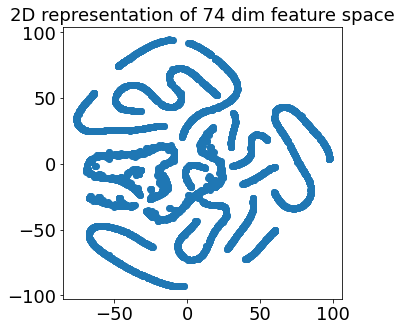

In [0]:
    X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
    X_embedded.shape
    pl.figure(figsize=(5,5))
    pl.scatter(X_embedded[:,0], X_embedded[:,1])
    print("Figure: the 2D projection of the 68-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")
    
    SMALL_SIZE = 18
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
    pl.title('2D representation of 74 dim feature space')
    pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    axis_font = {'fontname':'Computer Modern Roman', 'size':'24'}
    # pl.xlabel("mjd", **axis_font)
    # pl.ylabel("flux", **axis_font)
    pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

Fig3 : 2D representation of higher dimentional feature space. 



*       "How many clusters can you see in this embedding?" 
* Although we see some finite number of clustering. But it is hard to tell by only looking at the figure the total number of clusters. There might be code resource available that will allow us to find excat number of clusters. 

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

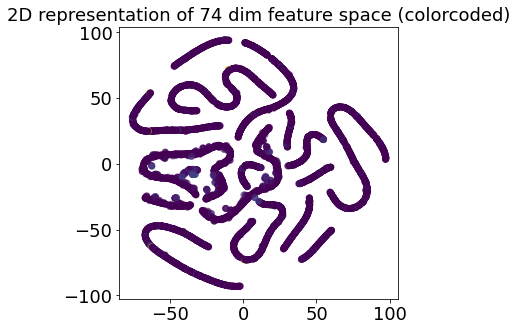

In [0]:
    norm_obj= Normalize(vmin=y.min(), vmax=y.max())
    len([c for c in pl.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
    pl.figure(figsize=(5,5))
    pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y.values))], alpha=0.5);

    
    SMALL_SIZE = 18
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
    pl.title('2D representation of 74 dim feature space (colorcoded)')
    pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    axis_font = {'fontname':'Computer Modern Roman', 'size':'24'}
    # pl.xlabel("mjd", **axis_font)
    # pl.ylabel("flux", **axis_font)
    pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

**Figure4**: the purity of the sample is not good in the t-SNE projection against the target variable. Shown in colorplots which adds more clustering.

Does this map better on other features in the metadata?
Ans : The figure is slightly better given one can separate some feature cluster from another. 

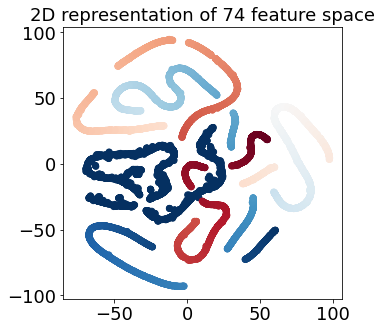

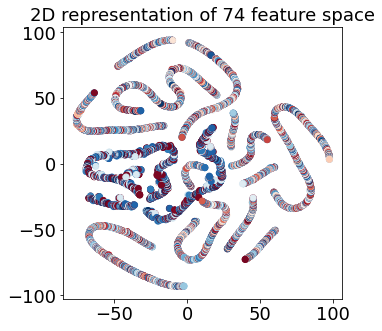

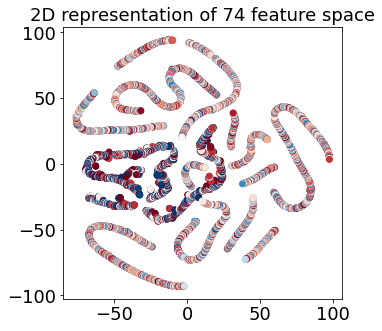

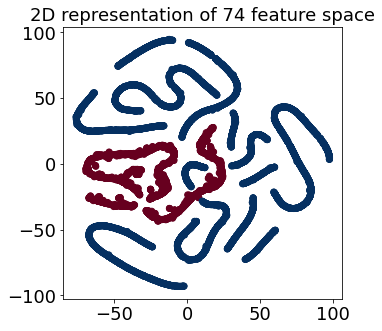

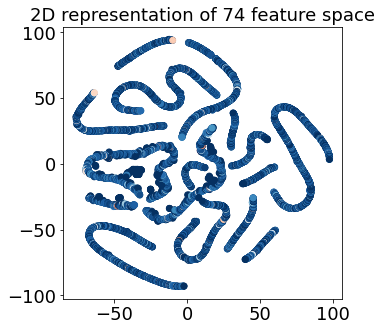

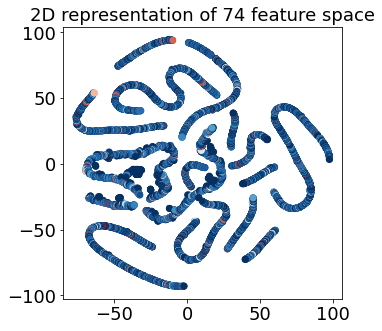

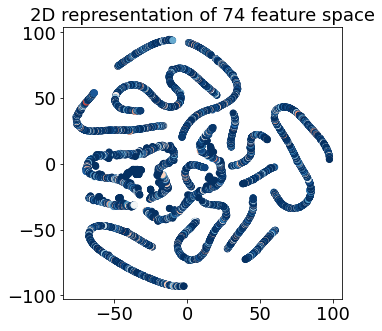

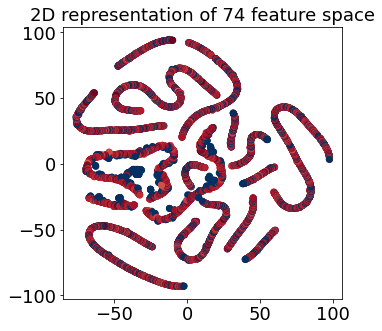

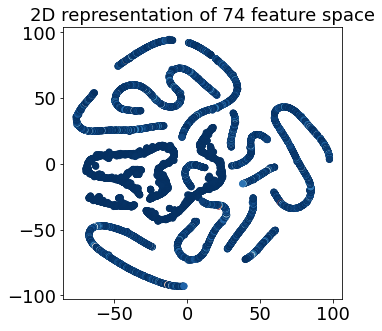

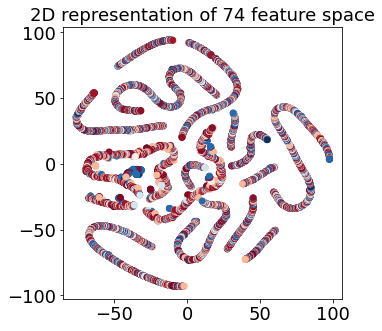

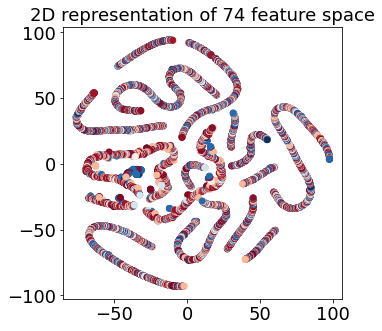

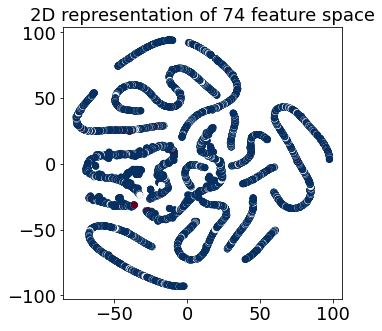

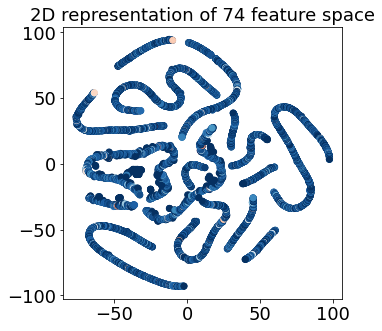

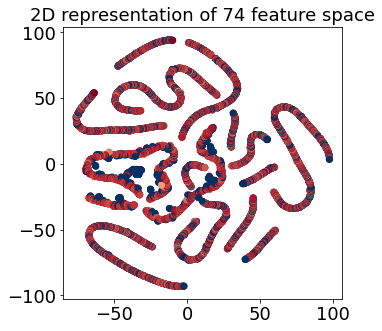

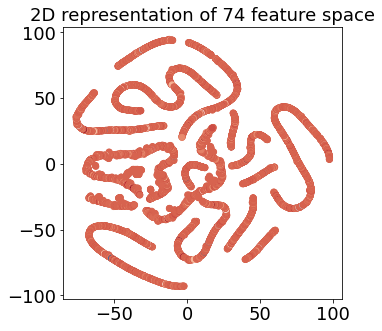

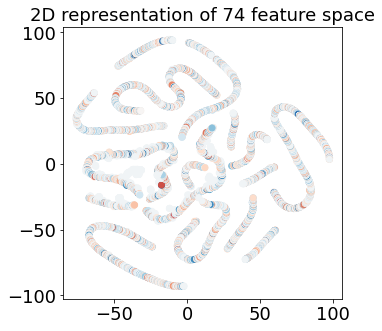

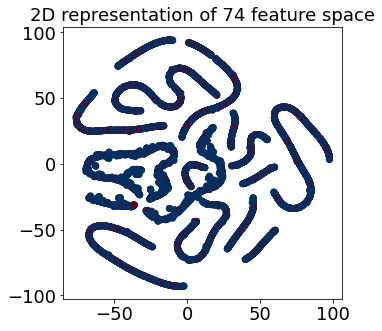

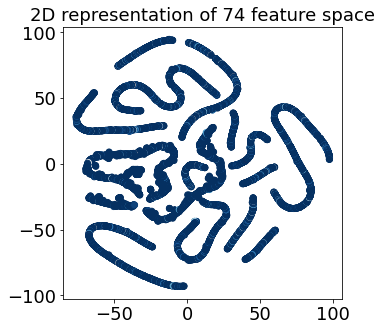

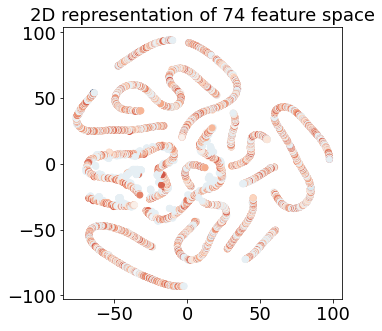

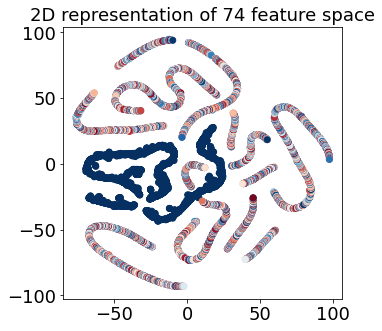

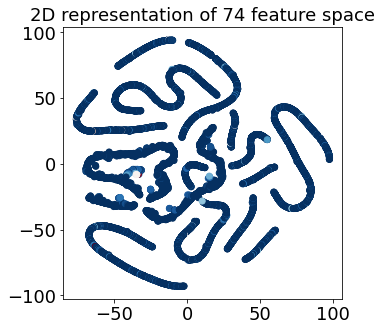

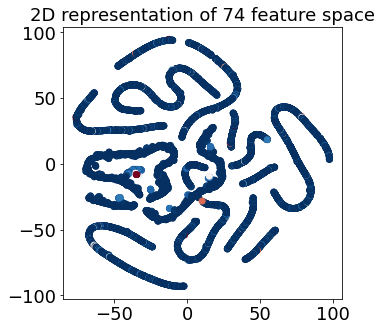

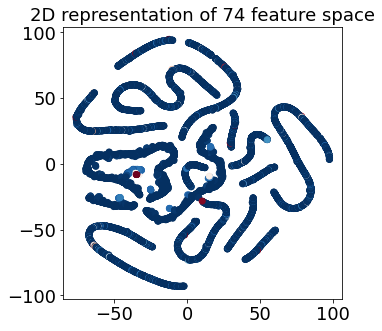

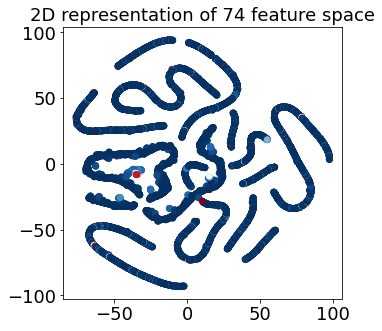

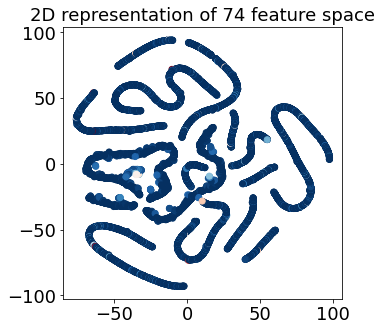

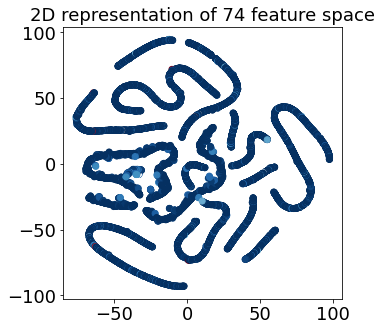

In [0]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    pl.figure(figsize=(5,5))
    pl.title(col)
    pl.scatter(X_embedded[:,0], X_embedded[:,1],
               color=[pl.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    
    SMALL_SIZE = 18
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
    pl.title('2D representation of 74 feature space')
    pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    axis_font = {'fontname':'Computer Modern Roman', 'size':'24'}
    # pl.xlabel("mjd", **axis_font)
    # pl.ylabel("flux", **axis_font)
    pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

    pl.show()

Fig5: 2D visualizattion of 74 dimentional feature space. 